# Sentiment Analysis
**Fine-tuning Bert Model**<br>


Shubhangi Sanyal (MDS202238)

In [36]:
import numpy as np
import pandas as pd
import datetime, time, copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertTokenizerFast, BertForSequenceClassification, get_linear_schedule_with_warmup

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [3]:
df_train = pd.read_csv("/kaggle/input/dataset/sentiment_analysis_data/train.csv")
df_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km),Density (P/Km)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:
df_train.dropna(subset=['text', 'sentiment'], inplace=True)

In [5]:
df_train.shape

(27480, 10)

In [6]:
# check class distribution
df_train['sentiment'].value_counts(normalize = True)

sentiment
neutral     0.404549
positive    0.312300
negative    0.283151
Name: proportion, dtype: float64

In [7]:
df_test = pd.read_csv("/kaggle/input/dataset/sentiment_analysis_data/test.csv",encoding="iso-8859-1")
df_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [8]:
df_test.dropna(subset=['text', 'sentiment'],inplace=True)

In [9]:
df_test.shape

(3534, 9)

In [10]:
df_test['sentiment'].value_counts(normalize=True)

sentiment
neutral     0.404641
positive    0.312111
negative    0.283248
Name: proportion, dtype: float64

# Pre-process text

In [13]:
import re

def preprocess_text(text):
    # Remove float objects
    if isinstance(text, float):
        return ''
    # Replace NaNs with space
    if pd.isna(text):
        return ''
    text = text.lower() # Lowercase the text  
    text = re.sub(r'\d', '', text) # Remove numbers    
    text = re.sub(r'[^\w\s]', '', text) # Remove special characters    
    text = re.sub(r"\S*@\S*\s?", '', text) # Remove emails    
    text = re.sub(r'http\S+', '', text) # Remove URLs
    return text


In [14]:
df_train['clean_text'] = df_train['text'].apply(preprocess_text)
df_test['clean_text'] = df_test['text'].apply(preprocess_text)

In [15]:
# Define a dictionary to map original labels to encoded labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

# Map the original labels to encoded labels
df_train['encoded_sentiment'] = df_train['sentiment'].map(label_map)
df_test['encoded_sentiment'] = df_test['sentiment'].map(label_map)

# Split train dataset into train, validation and test sets

In [16]:
train_text, val_text, train_labels, val_labels = train_test_split(df_train['clean_text'], 
                                                                  df_train['encoded_sentiment'],
                                                                  random_state=2018,
                                                                  test_size=0.2,
                                                                  stratify=df_train['encoded_sentiment'])

test_text = df_test['clean_text']
test_labels = df_test['encoded_sentiment']

# Import BERT Model and BERT Tokenizer

In [30]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for pos/neu/neg classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Tokenization

<Axes: >

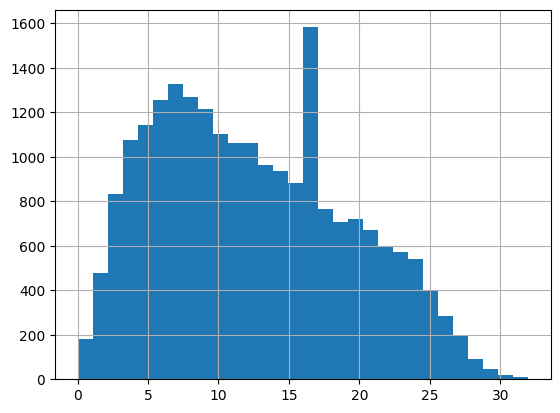

In [18]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [19]:
max_seq_len = 25

In [23]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding = 'max_length',
    truncation=True
    #return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding = 'max_length',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding = 'max_length',
    truncation=True
)

# Convert Integer Sequences to Tensors

In [24]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [25]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# View the model

In [31]:
model.to(device)
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Set up model parameters

In [34]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [49]:
# Number of training epochs
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [50]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Model Training

In [51]:
# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear Gradients
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch)
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        loss, logits = output.loss, output.logits

        # Accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Time required to train epoch: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            output = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

            loss, logits = output.loss, output.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation time: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch   100  of    687.    Elapsed: 0:00:10.
  Batch   200  of    687.    Elapsed: 0:00:20.
  Batch   300  of    687.    Elapsed: 0:00:30.
  Batch   400  of    687.    Elapsed: 0:00:40.
  Batch   500  of    687.    Elapsed: 0:00:50.
  Batch   600  of    687.    Elapsed: 0:01:00.

  Average training loss: 0.18
  Time required to train epoch: 0:01:09

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.91
  Validation time: 0:00:05

======== Epoch 2 / 10 ========
Training...
  Batch   100  of    687.    Elapsed: 0:00:10.
  Batch   200  of    687.    Elapsed: 0:00:20.
  Batch   300  of    687.    Elapsed: 0:00:30.
  Batch   400  of    687.    Elapsed: 0:00:40.
  Batch   500  of    687.    Elapsed: 0:00:51.
  Batch   600  of    687.    Elapsed: 0:01:01.

  Average training loss: 0.15
  Time required to train epoch: 0:01:09

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.95
  Validation time: 0:00:05

======== Epoch 3 / 10 =

In [52]:
trained_model = copy.deepcopy(model)
#torch.save(trained_model,'/kaggle/working/models/fine_tuned_bert_model' + '.t7')
torch.save(trained_model.state_dict(), 'fine_tuned_bert_model.pth')

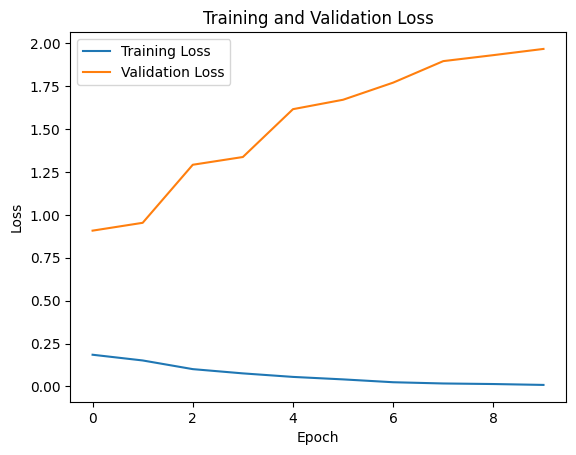

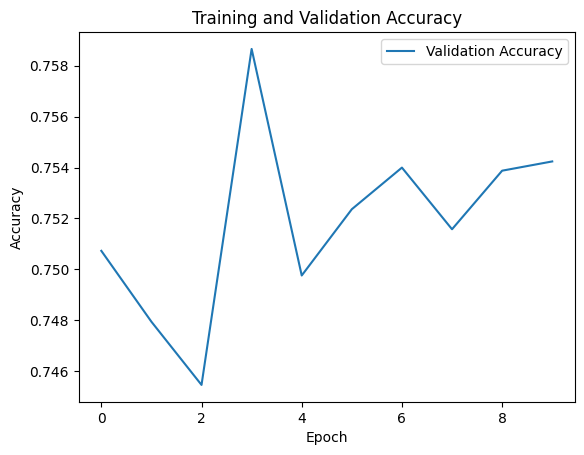

In [53]:
import matplotlib.pyplot as plt

def plot_loss(training_stats):
    # Plot the training and validation loss
    plt.plot([stats['Training Loss'] for stats in training_stats], label='Training Loss')
    plt.plot([stats['Valid. Loss'] for stats in training_stats], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(training_stats):
    # Plot the training and validation accuracy
    plt.plot([stats['Valid. Accur.'] for stats in training_stats], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Usage example:
# After training, call these functions passing the training_stats list as an argument.
plot_loss(training_stats)
plot_accuracy(training_stats)

In [54]:
with torch.no_grad():
  preds = trained_model(test_seq.to(device), test_mask.to(device))

In [55]:
logits_tensor = preds.logits

# Convert logits tensor to numpy array
logits_numpy = logits_tensor.cpu().numpy()

# Classification Report

In [56]:
preds = np.argmax(logits_numpy, axis = 1)
# Define custom class labels
class_labels = ['negative', 'neutral', 'positive']
print(classification_report(test_y, preds, target_names=class_labels))

              precision    recall  f1-score   support

    negative       0.77      0.77      0.77      1001
     neutral       0.73      0.77      0.75      1430
    positive       0.85      0.78      0.81      1103

    accuracy                           0.77      3534
   macro avg       0.78      0.77      0.78      3534
weighted avg       0.78      0.77      0.77      3534

